In [2]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import math
import copy
import pickle

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *


In [4]:
def longlat2km(lat1, long1, lat2, long2):
    D = 40075 # km
    dy = (lat1-lat2) * 111.32
    dx = (long1 - long2)*(D * np.cos((lat1+lat2)/(2 * 180 )))/(360)
    
    return dy, dx

def load_usr(db, ts_min_size = 5):
    cnx = sqlite3.connect(db)
    df = pd.read_sql_query("SELECT * FROM locationTable", cnx)

    cnx.close()

    df = df[df['_activity'] == 2]
    df = df[df['_latitude']>0]
    df = df[df['_longitude']>0]
    
    times = np.array(df['_time_location'])
    date_list = []
    hr_list = []
    min_list = []
    ts_list = []
    

    for t in times:
        date_list+= [t[4:-9]]
        hr_list+= [int(t[8:-7])]
        min_list += [int(t[10:-5])]
        ts_list += [np.round((hr_list[-1]*60 + min_list[-1])/ts_min_size)]
        
    df['Date'] = date_list
    df['Hr'] = hr_list
    df['Min'] = min_list
    df['ts'] = ts_list

    
    lat = np.array(df['_latitude']*10e-7)
    long = np.array(df['_longitude']*10e-7)

    mean_lat = np.mean(lat)
    mean_long =  np.mean(long)

    dx,dy = longlat2km(lat,long,mean_lat,mean_long)

    df['x_loc'] = dx/1.6
    df['y_loc']= dy/1.6 # Change to miles

    df_copy = df
    
    df = df.drop(['_node_id','_latitude_gps','_longitude_gps','_latitude_wifi','_longitude_wifi',
             '_altitude','_accuracy','_accuracy_gps','_accuracy_wifi','_place_name','_place_comment',
                 '_latitude','_longitude','_activity','_time_location'], axis=1)

    
    traces = {}
    
    for date in date_list:
        temp_df = np.array(df[df["Date"]==date])[:,3:]
        
        # Normalize X and Y here to be average for that date (mean = 0)
        ts = temp_df[:,0]
        x = temp_df[:,1] # - np.mean(np.unique(temp_df[:,1]))
        y = temp_df[:,2] # - np.mean(np.unique(temp_df[:,2]))
        
        temp_df[:,1] = x
        temp_df[:,2] = y
        
        temp_final = np.empty([0,3])
        temp_final = np.append(temp_final,np.reshape(temp_df[0],[1,3]),axis=0)
                
        for i in range(ts.shape[0]-1):
            t2 = int(ts[i+1])
            t1 = int(ts[i])
            
            row_2 = temp_df[i+1,:]
            row_1 = temp_df[i,:]
            
            t_diff = t2 - t1
            
            # Extrapolate
            if t_diff > 1:
                times = range(t1+1,t2+1)
                del_x = x[i+1]-x[i]
                del_y = y[i+1]-y[i]
                
                ratio_count = 1
                
                for t in times:
                    temp_x = x[i] + (ratio_count/t_diff) * del_x
                    temp_y = y[i] + (ratio_count/t_diff) * del_y
                    
                    temp = np.array([[t,temp_x,temp_y]])
                    temp_final = np.append(temp_final,temp,axis=0)
                    
                    ratio_count += 1
                
            # Delete one of the cases    
            elif t_diff == 0:
                continue
                
            # Proceed as normal    
            elif t_diff == 1:
                temp_final = np.append(temp_final,np.reshape(row_2,[1,3]),axis=0)
            
        traces[date] = temp_final
    
    return df, traces #, df_copy


In [5]:
# a,b,c = load_usr("LifeMap_GS1.db")

In [6]:
# min(c["_longitude"])*10e-7

In [7]:
# max(a['x_loc'])

In [10]:
db_start = "crawdad_mobility/LifeMap_GS"
df = {}
traces = {}

for i in range(1,13):
    print("round", i)
    db = db_start + str(i) + ".db"
    df[i], traces[i] = load_usr(db)

round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12


In [11]:
# Combine all time steps into one long run
traces_combined = {}

for i in range(1,13):
    key = list(traces[i])[0]
    size = traces[i][key].shape[1]
    
    temp = np.empty([0,size])
    
    for k in traces[i].keys():
        temp = np.append(temp, traces[i][k],axis=0)
        
    traces_combined[i] = temp

In [12]:
# Normalize movement
for i in range(1,13):
    temp = traces_combined[i]
    print(i, "x_min:", min(temp[1]), "x_max:", max(temp[1]), "y_min:", min(temp[2]), "y_max:", max(temp[2]))

1 x_min: -7.836966219229323 x_max: 139.0 y_min: -7.6697193733674585 y_max: 140.0
2 x_min: -12.386985776665616 x_max: 116.0 y_min: -12.386985776665616 y_max: 117.0
3 x_min: -10.189351274697566 x_max: 180.0 y_min: -10.189181113883114 y_max: 181.0
4 x_min: -2.4118381801867588 x_max: 91.0 y_min: -2.382313824304387 y_max: 92.0
5 x_min: -32.75479072651423 x_max: 146.0 y_min: -32.73560976205753 y_max: 147.0
6 x_min: 1.780992654644033 x_max: 100.0 y_min: 1.666976229622524 y_max: 159.0
7 x_min: -14.33946071515848 x_max: 188.0 y_min: -14.33946071515848 y_max: 189.0
8 x_min: -5.223098499249298 x_max: 225.0 y_min: -6.23508037665874 y_max: 226.0
9 x_min: -20.73090518165497 x_max: 143.0 y_min: -20.72457601203177 y_max: 144.0
10 x_min: 0.5714722707835729 x_max: 165.0 y_min: 0.5717351358756639 y_max: 166.0
11 x_min: 0.8021797983453524 x_max: 21.0 y_min: -0.5886626974673239 y_max: 22.0
12 x_min: -6.286122754884955 x_max: 223.0 y_min: -4.9281554155419816 y_max: 224.0


In [13]:
# Normalize movement
for i in range(1,13):
    temp = traces_combined[i]
    print(i, "x_diff:", max(temp[1]) - min(temp[1]), "y_diff:", max(temp[2]) - min(temp[2]))

1 x_diff: 146.8369662192293 y_diff: 147.66971937336746
2 x_diff: 128.38698577666563 y_diff: 129.38698577666563
3 x_diff: 190.18935127469757 y_diff: 191.1891811138831
4 x_diff: 93.41183818018676 y_diff: 94.38231382430439
5 x_diff: 178.75479072651422 y_diff: 179.73560976205752
6 x_diff: 98.21900734535596 y_diff: 157.33302377037748
7 x_diff: 202.33946071515848 y_diff: 203.33946071515848
8 x_diff: 230.2230984992493 y_diff: 232.23508037665874
9 x_diff: 163.73090518165498 y_diff: 164.72457601203178
10 x_diff: 164.42852772921643 y_diff: 165.42826486412434
11 x_diff: 20.197820201654647 y_diff: 22.588662697467324
12 x_diff: 229.28612275488496 y_diff: 228.928155415542


In [ ]:
# Normalize and divide data
# Add noise to data
mu = 0
sigma = 2
mu1 = 0
sigma1 = 1.5
traces_normalized = {}
for i in range(1,13): 
    temp = copy.deepcopy(traces_combined[i])
    s1 = np.random.normal(mu, sigma, 1)
    s2 = np.random.normal(mu, sigma, 1)
    s3 = np.random.normal(mu1, sigma1, temp[:,1].shape[0])
    s4 = np.random.normal(mu1, sigma1, temp[:,2].shape[0])
    temp[:,1] = (temp[:,1] - np.median(temp[:, 1]))/20 + 3.5 + s1 + s3
    temp[:,2] = (temp[:,2] - np.median(temp[:,2]))/20 -3 +s2 + s4
    traces_normalized[i] = temp

In [ ]:
# Repeat traces to fulfill rounds
goal = 40000

traces_normalized_repeated = {}

key = list(traces[1])[1]
size = traces[1][key].shape[1]


# check the number of time steps for each user
for i in range(1,13):
    trace_len = traces_normalized[i].shape[0]
    repeat_times = goal/trace_len
    num_repeat = int(np.ceil(repeat_times))
    temp = np.empty([0,size])
    temp2 = traces_normalized[i]
    
    for t in range(num_repeat):
        if t%2 == 0:
            temp = np.append(temp, temp2,axis=0)
        else:
            temp = np.append(temp, np.flip(temp2, 0), axis=0)

    temp[:,0] = np.arange(temp.shape[0])
            
    traces_normalized_repeated[i-1] = temp[:goal]

In [ ]:
traces_normalized_repeated[0]

In [ ]:
# Plot all locations to see concentration
import matplotlib.pyplot as plt
for i in range(0,12):
    if i != 7 and i != 11:
# i = 5
        plt.plot(traces_normalized_repeated[i][:,1], traces_normalized_repeated[i][:,2], 'o')
plt.show()

In [63]:
with open("traces_normalized_40k.pkl", "wb") as tf:
    pickle.dump(traces_normalized_repeated,tf)

In [64]:
with open('traces_normalized_40k.pkl', 'rb') as handle:
    b = pickle.load(handle)

In [65]:
num_svr = 9
num_usr_loc = 9
# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=5, nums=num_usr_loc,offset = 1)
svr_locs = gen_eq_locs(space_1d=5, nums=num_svr,offset = 1)

offset_x = 0
offset_y = 5
for i in range(len(usr_locs)):
    usr_locs[i] = (usr_locs[i][0]-offset_x, usr_locs[i][1]-offset_y)
for i in range(len(svr_locs)):
    svr_locs[i] = (svr_locs[i][0]-offset_x, svr_locs[i][1]-offset_y)


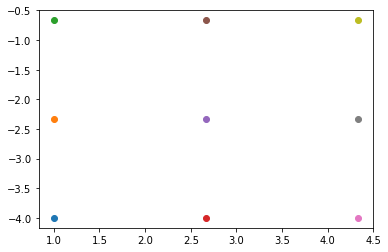

In [66]:
for i in range(len(usr_locs)):
    plt.plot(usr_locs[i][0],usr_locs[i][1], 'o')
plt.show()

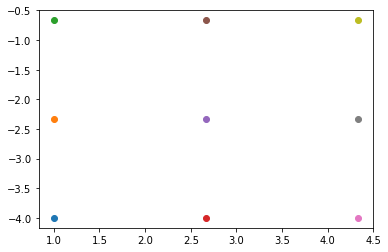

In [67]:
for i in range(len(svr_locs)):
    plt.plot(svr_locs[i][0],svr_locs[i][1], 'o')
plt.show()

In [68]:
traces_discretized = {}
for i in range(0,12):
    T = goal
    load_trace = traces_normalized_repeated[i]
    closest = np.zeros(goal)
    for t in range(goal):
        temp = np.zeros(num_usr_loc)
        x1 = load_trace[t,1]
        y1 = load_trace[t,2]
        for j in range(num_usr_loc):
            x2 = usr_locs[j][0]
            y2 = usr_locs[j][1]
            temp[j] = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        closest[t] = np.random.choice(np.where(temp == temp.min())[0])
    traces_discretized[i] = closest
        

In [72]:
traces_discretized[8][9000:10000]

array([6., 7., 7., 6., 6., 6., 6., 6., 7., 6., 6., 6., 7., 7., 6., 6., 6.,
       7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 7., 6., 7.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6.,
       6., 6., 7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 6.,
       6., 7., 6., 7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       7., 6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 6., 6., 6., 6., 7., 6.,
       6., 7., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 6., 7., 6., 6.,
       6., 7., 6., 6., 6., 6., 6., 6., 6., 7., 6., 6., 6., 7., 6., 7., 6.,
       6., 6., 6., 6., 6.

In [73]:
P_dict = {}
for i in range(0,12):
    P_temp = np.zeros([num_usr_loc,num_usr_loc])
    for t in range(goal-1):
        x = int(traces_discretized[i][t])
        y = int(traces_discretized[i][t+1])
        P_temp[x,y] += 1
    for j in range(num_usr_loc):
        P_temp[j] = P_temp[j]/(np.sum(P_temp[j]) + 0.0000001)
    # Fixing bad rows where movement doesn't occur to
    default_state = np.random.choice(np.where(np.sum(P_temp,axis=0) > 0.5)[0])
    for j in range(num_usr_loc):
        if np.sum(P_temp[j]) < 0.5 :
            P_temp[j,default_state] = 1
    P_dict[i] = P_temp

In [74]:
P_dict[0]

array([[8.94736841e-01, 5.26315789e-02, 0.00000000e+00, 3.94736842e-02,
        0.00000000e+00, 0.00000000e+00, 1.31578947e-02, 0.00000000e+00,
        0.00000000e+00],
       [7.99999998e-02, 2.79999999e-01, 6.39999999e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.13333333e-01, 7.86666666e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [6.52173913e-03, 0.00000000e+00, 0.00000000e+00, 2.73913043e-01,
        0.00000000e+00, 0.00000000e+00, 7.19565217e-01, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

In [75]:
with open("traces_P_40k.pkl", "wb") as tf:
    pickle.dump(P_dict,tf)

In [76]:
with open("traces_discretized_40k.pkl", "wb") as tf:
    pickle.dump(traces_discretized,tf)